In [4]:
#Import needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
import xgboost as xgb 

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from datetime import datetime 


In [5]:
#Load data file without customerID
df = pd.read_csv('data/TelcoCustomerChurn.csv', na_values=[' ']).drop('customerID', axis=1)

## Data Understanding

In [7]:
df.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0              Yes           Electronic check           29.85         29.85   
1               No               Mailed check           56.95       1889.50   
2              Yes               Mailed check           53.85        108.15   
3               No  Bank transfer (automatic)           42.30       1840.75   
4              Yes           Electronic check           70.70        151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [60]:
df.shape

(7043, 20)

In [61]:
TARGET = 'Churn'

In [62]:
df[TARGET].value_counts()

No     5174
Yes    1869
Name: Churn, dtype: int64

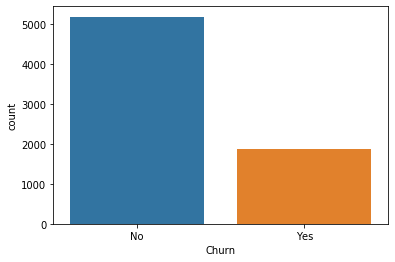

In [63]:
sns.countplot(data=df, x=TARGET);

In [64]:
#Get categorical and numerical data
categorical_features = [
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
]
numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
target = 'Churn'

In [65]:
df[numerical_features].describe()

tenure  MonthlyCharges  TotalCharges
count  7043.000000     7043.000000   7032.000000
mean     32.371149       64.761692   2283.300441
std      24.559481       30.090047   2266.771362
min       0.000000       18.250000     18.800000
25%       9.000000       35.500000    401.450000
50%      29.000000       70.350000   1397.475000
75%      55.000000       89.850000   3794.737500
max      72.000000      118.750000   8684.800000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe75f87ac50>,
      dtype=object)

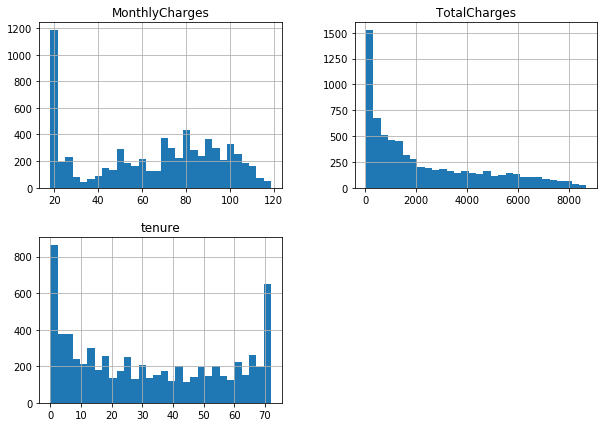

In [66]:
df[numerical_features].hist(bins=30, figsize=(10, 7))

/Users/fabian/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='bar')` instead of `Series.plot('bar',)`.
  


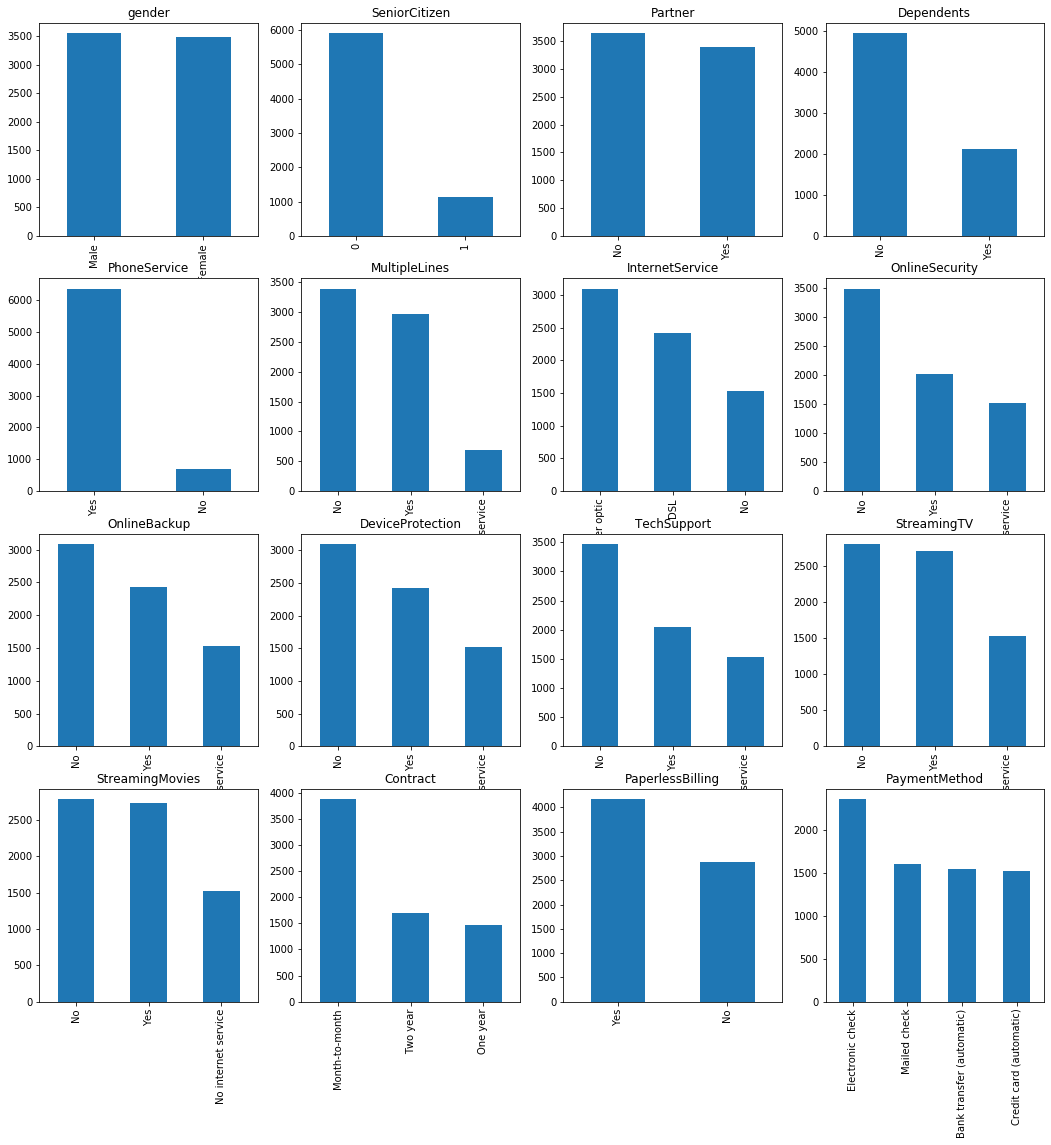

In [67]:
ROWS, COLS = 4, 4
fig, ax = plt.subplots(ROWS, COLS, figsize=(18, 18))
row, col = 0, 0
for i, categorical_feature in enumerate(categorical_features):
    if col == COLS - 1:
        row += 1
    col = i % COLS
    df[categorical_feature].value_counts().plot('bar', ax=ax[row, col]).set_title(categorical_feature)

In [68]:
df[numerical_features].corr()

tenure  MonthlyCharges  TotalCharges
tenure          1.00000        0.247900      0.825880
MonthlyCharges  0.24790        1.000000      0.651065
TotalCharges    0.82588        0.651065      1.000000

## Data Preprocessing

In [69]:
#Check Types. lightGBM does not work with object
df.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [70]:
#Convert all the non-numeric columns to numerical data types
for column in df.columns:
   if df[column].dtype == np.number:
      continue
   df[column] = LabelEncoder().fit_transform(df[column])

In [71]:
df.isnull().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [72]:
#Drop all rows with NaN data
df = df.dropna() 

In [73]:
#Check if no object types are left
df.dtypes

gender                int64
SeniorCitizen         int64
Partner               int64
Dependents            int64
tenure                int64
PhoneService          int64
MultipleLines         int64
InternetService       int64
OnlineSecurity        int64
OnlineBackup          int64
DeviceProtection      int64
TechSupport           int64
StreamingTV           int64
StreamingMovies       int64
Contract              int64
PaperlessBilling      int64
PaymentMethod         int64
MonthlyCharges      float64
TotalCharges        float64
Churn                 int64
dtype: object

In [74]:
df.head()

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0       0              0        1           0       1             0   
1       1              0        0           0      34             1   
2       1              0        0           0       2             1   
3       1              0        0           0      45             0   
4       0              0        0           0       2             1   

   MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
0              1                0               0             2   
1              0                0               2             0   
2              0                0               2             2   
3              1                0               2             0   
4              0                1               0             0   

   DeviceProtection  TechSupport  StreamingTV  StreamingMovies  Contract  \
0                 0            0            0                0         0   
1                 2            0            0                0         1   
2                 0            0            0                0         0   
3                 2            2            0                0         1   
4                 0            0            0                0         0   

   PaperlessBilling  PaymentMethod  MonthlyCharges  TotalCharges  Churn  
0                 1              2           29.85         29.85      0  
1                 0              3           56.95       1889.50      0  
2                 1              3           53.85        108.15      1  
3                 0              0           42.30       1840.75      0  
4                 1              2           70.70        151.65      1

In [75]:
df.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [76]:
df.shape

(7032, 20)

In [77]:
Y = df["Churn"].values
X = df.drop(labels = ["Churn"],axis = 1)
#Scaler has bad impact on results but can be activated
#X = StandardScaler().fit_transform(X)


In [78]:
#Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

## Test Random Forrest

In [79]:
#Perform Quick Random Forrest to check Acc
from sklearn.ensemble import RandomForestClassifier

In [80]:
clf = RandomForestClassifier(max_depth=7, random_state=0)

In [81]:
clf.fit(X_train, y_train)

/Users/fabian/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [82]:
y_pred=clf.predict(X_test)

In [83]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7931769722814499


## LightGBM

In [84]:
#Split data into labeled test and train data set 
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [85]:
#Setup parameters for lightGBM
params = {'num_boost_round':250, #Iterations
         'num_leaves':100,
         'objective':'binary',
         'max_depth':5, #Max Tree Depth
         'learning_rate':.05,
         'max_bin':100,
         'boosting_type':'gbdt',
         'min_data_in_leaf': 2000
        }
params['metric'] = ['auc', 'binary_logloss']



### Wichtige Parameter

**objective** (default: 'regression'), (z.B. 'regression', 'binary', 'multiclass'): Legt das Target fest. In diesem Fall Binary da Churn 0 oder 1 darstellt.

**boosting_type** (default: 'gbdt'), ('gbdt','rf', 'dart', 'goss'): 
- gbdt, traditional Gradient Boosting Decision Tree, aliases: gbrt
- rf, Random Forest, aliases: random_forest
- dart, Dropouts meet Multiple Additive Regression Trees
- goss, Gradient-based One-Side Sampling

**num_boost_round** (default: 100) (int > 0): Anzahl der Iterationen. Kann mit Early Stopping abgebrochen werden um Overfitting zu vermeiden

**num_leaves** (default: 31), (int > 0): Hauptparameter um die Komplexität des Modells einzugrenzen. Sollte maximal 2^may_depth entsprechen um Overfitting zu vermeiden. Tendenziell etwas niedriger wählen.

**min_data_in_leaf** (default: 20),(int > 0): Zur Vermeidung von Overfitting, hoher Wert verhindert einen tiefen Baum kann aber zu Underfitting führen. 

**max_depth** (default: -1), (int > 0, -1): Zur manuellen Begrenzung der Baumtiefe.




In [86]:
evals_result = {}  # to record eval results for plotting
#Fit lightGBM Modell
clf = lgb.train(params,
                d_train,
                valid_sets=[d_train, d_test],
                evals_result=evals_result,
                early_stopping_rounds=10
               )

/Users/fabian/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	training's auc: 0.731649	training's binary_logloss: 0.570767	valid_1's auc: 0.712208	valid_1's binary_logloss: 0.571512
Training until validation scores don't improve for 10 rounds
[2]	training's auc: 0.731649	training's binary_logloss: 0.563286	valid_1's auc: 0.712208	valid_1's binary_logloss: 0.564705
[3]	training's auc: 0.731649	training's binary_logloss: 0.556487	valid_1's auc: 0.712208	valid_1's binary_logloss: 0.558549
[4]	training's auc: 0.731649	training's binary_logloss: 0.550301	valid_1's auc: 0.712208	valid_1's binary_logloss: 0.552976
[5]	training's auc: 0.731649	training's binary_logloss: 0.544665	valid_1's auc: 0.712208	valid_1's binary_logloss: 0.547925
[6]	training's auc: 0.731649	training's binary_logloss: 0.539524	valid_1's auc: 0.712208	valid_1's binary_logloss: 0.543344
[7]	training's auc: 0.731649	training's binary_logloss: 0.534831	valid_1's auc: 0.712208	valid_1's binary_logloss: 0.539187
[8]	training's auc: 0.786341	training's binary_logloss: 0.530402	valid_

[205]	training's auc: 0.841365	training's binary_logloss: 0.423992	valid_1's auc: 0.82168	valid_1's binary_logloss: 0.442633
[206]	training's auc: 0.841353	training's binary_logloss: 0.423946	valid_1's auc: 0.821716	valid_1's binary_logloss: 0.442644
[207]	training's auc: 0.841438	training's binary_logloss: 0.423902	valid_1's auc: 0.821714	valid_1's binary_logloss: 0.442602
[208]	training's auc: 0.841476	training's binary_logloss: 0.423858	valid_1's auc: 0.821745	valid_1's binary_logloss: 0.442555
[209]	training's auc: 0.841511	training's binary_logloss: 0.423814	valid_1's auc: 0.821763	valid_1's binary_logloss: 0.442491
[210]	training's auc: 0.841469	training's binary_logloss: 0.42377	valid_1's auc: 0.821734	valid_1's binary_logloss: 0.442516
[211]	training's auc: 0.841508	training's binary_logloss: 0.423727	valid_1's auc: 0.821812	valid_1's binary_logloss: 0.442422
[212]	training's auc: 0.841476	training's binary_logloss: 0.423685	valid_1's auc: 0.821872	valid_1's binary_logloss: 0.4

In [87]:
def render_metric(metric_name):
    ax = lgb.plot_metric(evals_result, metric=metric_name, figsize=(10, 5))
    plt.show()

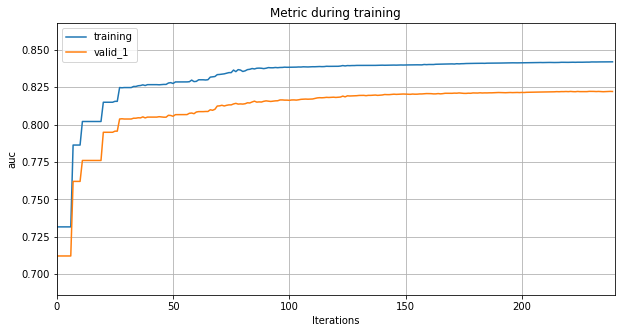

In [88]:
render_metric(params['metric'][0])

In [89]:
#Predict Test data
#Predictions are decimal values
y_pred=clf.predict(X_test)
y_pred


array([0.02050631, 0.09937181, 0.68283885, ..., 0.09394834, 0.08074624,
       0.02050631])

In [90]:
#Transform predictions to categorical churn. If prediction is > 0.5 then the customer churns
for i in range(len(y_pred)):
    if y_pred[i]>=.5:      
       y_pred[i]=1
    else:  
       y_pred[i]=0
y_pred

array([0., 0., 1., ..., 0., 0., 0.])

In [91]:
#Evaluate the model
#Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(y_pred,y_test)



In [92]:
print('Accuracy: ', accuracy)
print('Confusion Matrix: ')
print(cm)

Accuracy:  0.7960199004975125
Confusion Matrix: 
[[932 101]
 [186 188]]


In [93]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1033
           1       0.65      0.50      0.57       374

    accuracy                           0.80      1407
   macro avg       0.74      0.70      0.72      1407
weighted avg       0.78      0.80      0.79      1407



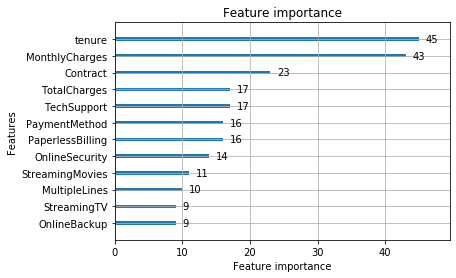

In [94]:
#Plot feature importances
feature_importance = lgb.plot_importance(clf, importance_type='split', max_num_features=20)

# Vergleich lightGBM und XGBoost

Ein großer Vorteil von lightGBM ist die Geschwindigkeit. Im folgenden Abschnitt soll exemplarisch gezeigt werden, wie schnell lightGBM im Vergleich zu XGBoost ist. Hierzu wird die Zeit beim Training des Modells gemessen.

Hierzu wird für XGBoost und lightGBM eine einfache Konfiguration eingestellt und die Trainingszeit wird verglichen.

### XGBoost Basic Setup

In [111]:
dtrain=xgb.DMatrix(X_train,label=y_train)
dtest=xgb.DMatrix(X_test)

In [112]:
parameters={'max_depth':7, 'eta':1, 'silent':1,'objective':'binary:logistic','eval_metric':'auc','learning_rate':.05}

In [113]:
num_round=100
from datetime import datetime 
start = datetime.now() 
xg=xgb.train(parameters,dtrain,num_round) 
stop = datetime.now()

[13:12:21] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




In [114]:
execution_time_xgboost = stop-start
execution_time_xgboost

datetime.timedelta(microseconds=365991)

In [115]:
ypred=xg.predict(dtest) 
ypred

array([0.014058  , 0.07546755, 0.7917351 , ..., 0.06433102, 0.17254435,
       0.00623151], dtype=float32)

In [116]:
for i in range(len(ypred)): 
    if ypred[i]>=.5:       # setting threshold to .5 
       ypred[i]=1 
    else: 
       ypred[i]=0  

In [117]:
accuracy_xgb = accuracy_score(y_test,ypred) 


### lightGBM Basic Setup

In [118]:
d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

In [119]:
param = {'num_leaves':100, 'objective':'binary','max_depth':7,'learning_rate':.05,'max_bin':200}
param['metric'] = ['auc', 'binary_logloss']

In [120]:
num_round=100
start=datetime.now()
lgbm=lgb.train(param,d_train,num_round)
stop=datetime.now()

In [121]:
execution_time_lgbm = stop-start
execution_time_lgbm

datetime.timedelta(microseconds=160973)

In [122]:
ypred2=lgbm.predict(X_test)
ypred2[0:5]  # showing first 5 predictions

array([0.00859721, 0.07120342, 0.72827709, 0.09351952, 0.39224755])

In [123]:
for i in range(len(ypred2)):
    if ypred2[i]>=.5:       # setting threshold to .5
       ypred2[i]=1
    else:  
       ypred2[i]=0

In [124]:
accuracy_lgbm = accuracy_score(ypred2,y_test)

### Zeitvergleich

In [125]:
time_dif = execution_time_xgboost-execution_time_lgbm

print("XGBoost Acc: ",accuracy_xgb, " Verbauchte Zeit: ", execution_time_xgboost)
print("lightGBM Acc: ",accuracy_lgbm, " Verbrauchte Zeit: ", execution_time_lgbm)
print("Zeitunterschied: ",time_dif)



XGBoost Acc:  0.7839374555792467  Verbauchte Zeit:  0:00:00.365991
lightGBM Acc:  0.7839374555792467  Verbrauchte Zeit:  0:00:00.160973
Zeitunterschied:  0:00:00.205018


Auswertung: Wie zusehen ist, verhält sich lightGBM deutlich schneller im Vergleich zu XGBoost bei ca. gleicher Performance. In diesem Fall ist LightGBM ca. 2 bis 3 Mal schneller beim Training.

### Vergleich mit deutlich höherer Anzahl an Iterationen
num_rounds = 1000

In [128]:
#Setup XGBoost with num_round = 100
num_round=100
from datetime import datetime 
start = datetime.now() 
xg=xgb.train(parameters,dtrain,num_round) 
stop = datetime.now()

execution_time_xgboost = stop-start
execution_time_xgboost

#Setup LightGBM with num_round = 100
num_round=100
start=datetime.now()
lgbm=lgb.train(param,d_train,num_round)
stop=datetime.now()


execution_time_lgbm = stop-start
execution_time_lgbm

#Compare results
time_dif = execution_time_xgboost-execution_time_lgbm

print("XGBoost Verbauchte Zeit: ", execution_time_xgboost)
print("LightGBM Verbrauchte Zeit: ", execution_time_lgbm)
print("Zeitunterschied: ",time_dif)

[13:13:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost Verbauchte Zeit:  0:00:13.157856
LightGBM Verbrauchte Zeit:  0:00:05.027018
Zeitunterschied:  0:00:08.130838


Wie zu sehen ist, verhält sich LightGBM auch bei einer deutlich größeren Anzahl an Iterationen deutlich schneller als XGBoost.

### Vergleich mit mehr Daten

LightGBM hat nicht nur Vorteile bei einer höheren Anzahl an num_round. Die bereits beobachteten Unterschiede lassen sich auch bei steigenden Datenmengen beobachten.

In [144]:
#Duplicate and concat exisiting df to get more data
#Use multiple times to grow df
df = pd.concat([df,df]).reset_index(drop=True)

In [145]:
#Show size of new dataset 
df.shape

(225024, 20)

In [150]:
#Generate temp df for testing
Y = df["Churn"].values
X = df.drop(labels = ["Churn"],axis = 1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [151]:
#Setup XGBoost with num_round = 100

dtrain=xgb.DMatrix(X_train,label=y_train)
dtest=xgb.DMatrix(X_test)

num_round=100
from datetime import datetime 
start = datetime.now() 
xg=xgb.train(parameters,dtrain,num_round) 
stop = datetime.now()

execution_time_xgboost = stop-start
execution_time_xgboost

#Setup LightGBM with num_round = 100

d_train = lgb.Dataset(X_train, label=y_train)
d_test = lgb.Dataset(X_test, label=y_test)

num_round=100
start=datetime.now()
lgbm=lgb.train(param,d_train,num_round)
stop=datetime.now()


execution_time_lgbm = stop-start
execution_time_lgbm

#Compare results
time_dif = execution_time_xgboost-execution_time_lgbm

print("XGBoost Verbauchte Zeit: ", execution_time_xgboost)
print("LightGBM Verbrauchte Zeit: ", execution_time_lgbm)
print("Zeitunterschied: ",time_dif)

[13:21:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


XGBoost Verbauchte Zeit:  0:00:06.639886
LightGBM Verbrauchte Zeit:  0:00:01.191305
Zeitunterschied:  0:00:05.448581


Bei steigender Datenmenge lässt sich sogar ein eine noch höhere Effizienz von lightGBM feststellen.
Bei einer wesentlich größeren Datenmenge ist lightGBM sogar 5 Mal schneller im Vergleich zu XGBoost.
Aus diesem Grund lohnt sich der Einsatz von LightGBM vor allem bei großen Datenmengen.